In [1]:
import os
import numpy as np
import torch 
import torch.nn.functional as F
import torch.nn as nn
from torch.distributions.normal import Normal
import gymnasium as gym
import matplotlib.pyplot as plt


In [3]:
env = gym.make("BipedalWalker-v3", hardcore=False)
env.reset()

(array([ 2.7459704e-03,  9.7193924e-06, -1.2673312e-03, -1.6000064e-02,
         9.2462800e-02,  2.9420296e-03,  8.5981905e-01, -9.3641860e-04,
         1.0000000e+00,  3.2787185e-02,  2.9419258e-03,  8.5354590e-01,
        -2.0017812e-03,  1.0000000e+00,  4.4081339e-01,  4.4581950e-01,
         4.6142212e-01,  4.8954949e-01,  5.3410202e-01,  6.0246021e-01,
         7.0914787e-01,  8.8593054e-01,  1.0000000e+00,  1.0000000e+00],
       dtype=float32),
 {})

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 77.2     |
|    ep_rew_mean     | -108     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 110      |
|    time_elapsed    | 2        |
|    total_timesteps | 309      |
| train/             |          |
|    actor_loss      | -5.22    |
|    critic_loss     | 1.79     |
|    ent_coef        | 0.94     |
|    ent_coef_loss   | -0.399   |
|    learning_rate   | 0.0003   |
|    n_updates       | 208      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 444      |
|    ep_rew_mean     | -122     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 77       |
|    time_elapsed    | 46       |
|    total_timesteps | 3555     |
| train/             

d:\Work\.venv\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward: 324.77 +/- 0.30


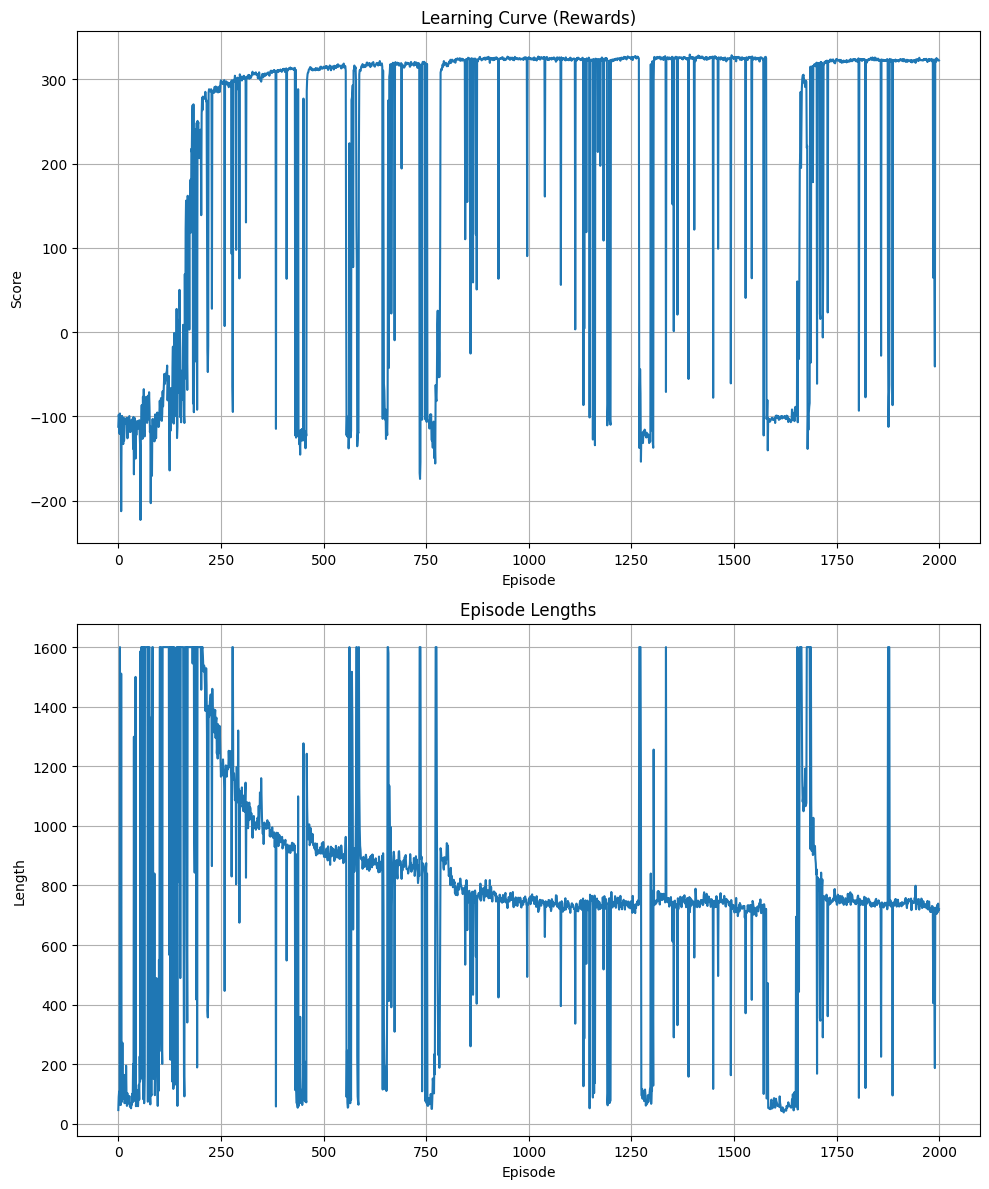

Training complete. Model and data saved.


In [13]:
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy

class EpisodeCallback(BaseCallback):
    def __init__(self, max_episodes, verbose=0):
        super().__init__(verbose)
        self.max_episodes = max_episodes
        self.episode_rewards = []
        self.episode_lengths = []

    def _on_step(self) -> bool:
        if len(self.episode_rewards) < self.max_episodes:
            if self.locals['dones'][0]:
                self.episode_rewards.append(self.locals['infos'][0]['episode']['r'])
                self.episode_lengths.append(self.locals['infos'][0]['episode']['l'])
                if len(self.episode_rewards) % 100 == 0:
                    print(f"Episode {len(self.episode_rewards)}/{self.max_episodes} completed")
        else:
            return False
        return True

# Create the environment
env = gym.make("BipedalWalker-v3", hardcore=False)

# Define hyperparameters
policy_kwargs = dict(net_arch=[256, 256])

model = SAC(
    "MlpPolicy", 
    env, 
    gamma=0.99,
    learning_rate=3e-4,
    buffer_size=500000,
    batch_size=256,
    tau=0.005,
    train_freq=1,
    gradient_steps=1,
    ent_coef="auto",
    target_update_interval=1,
    policy_kwargs=policy_kwargs,
    verbose=1,
)

# Set up the callback for episodic training
n_episodes = 2000
episode_callback = EpisodeCallback(max_episodes=n_episodes, verbose=1)

# Train the agent
model.learn(total_timesteps=int(1e10), callback=episode_callback)

# Evaluate the agent
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Save the model
model.save("sac_bipedalwalker_2000ep")

# Plotting function for learning curve
def plot_learning_curve(scores, lengths, figure_file):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    ax1.plot(scores)
    ax1.set_title('Learning Curve (Rewards)')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    
    ax2.plot(lengths)
    ax2.set_title('Episode Lengths')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Length')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(figure_file)
    plt.show()

# Create plots directory
figure_dir = os.path.join(os.getcwd(), 'plots')
os.makedirs(figure_dir, exist_ok=True)
figure_file = os.path.join(figure_dir, 'SB3_SAC_BipedalWalker_2000ep.png')

# Plot learning curve
plot_learning_curve(episode_callback.episode_rewards, episode_callback.episode_lengths, figure_file)

# Save collected data for further analysis
np.save('sb3_score_history.npy', np.array(episode_callback.episode_rewards))
np.save('sb3_episode_lengths.npy', np.array(episode_callback.episode_lengths))

# Calculate and save summary statistics
rewards_summary = {
    'mean': np.mean(episode_callback.episode_rewards),
    'std': np.std(episode_callback.episode_rewards),
    'min': np.min(episode_callback.episode_rewards),
    'max': np.max(episode_callback.episode_rewards)
}
np.save('sb3_rewards_summary.npy', rewards_summary)

print("Training complete. Model and data saved.")

In [12]:
if __name__ == '__main__':
    # Create the environment
    env = gym.make("BipedalWalker-v3", render_mode="rgb_array")
    
    # Set up video recording
    video_save_dir = os.path.join(os.getcwd(), 'videos')
    env = gym.wrappers.RecordVideo(env, video_save_dir, episode_trigger=lambda e: e == 0)  # Save only the first episode
    
    # Load the trained model
    model = SAC.load("sac_bipedalwalker_2000ep")  # Make sure this path is correct

    num_test_episodes = 5
    for episode in range(num_test_episodes):
        observation, _ = env.reset()
        terminated = False
        truncated = False
        total_reward = 0
        steps = 0

        while not terminated and not truncated:
            action, _ = model.predict(observation, deterministic=True)
            observation_, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            observation = observation_
            steps += 1
            env.render()

        print(f"Test Episode {episode + 1}: Total Reward: {total_reward:.2f}, Steps: {steps}")

    env.close()
    print(f"Video saved in {video_save_dir}")

d:\Work\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at d:\Work\RL\Project\SAC_base\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Test Episode 1: Total Reward: 321.48, Steps: 708
Test Episode 2: Total Reward: 322.73, Steps: 711
Test Episode 3: Total Reward: 322.82, Steps: 706
Test Episode 4: Total Reward: 322.47, Steps: 698
Test Episode 5: Total Reward: 322.64, Steps: 713
Video saved in d:\Work\RL\Project\SAC_base\videos


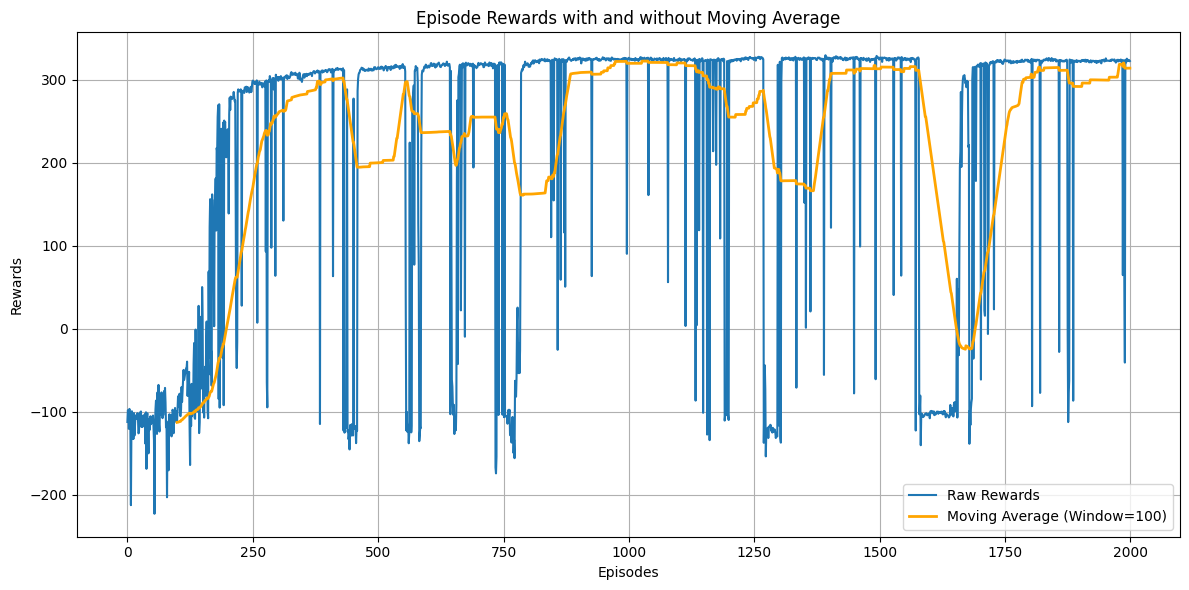

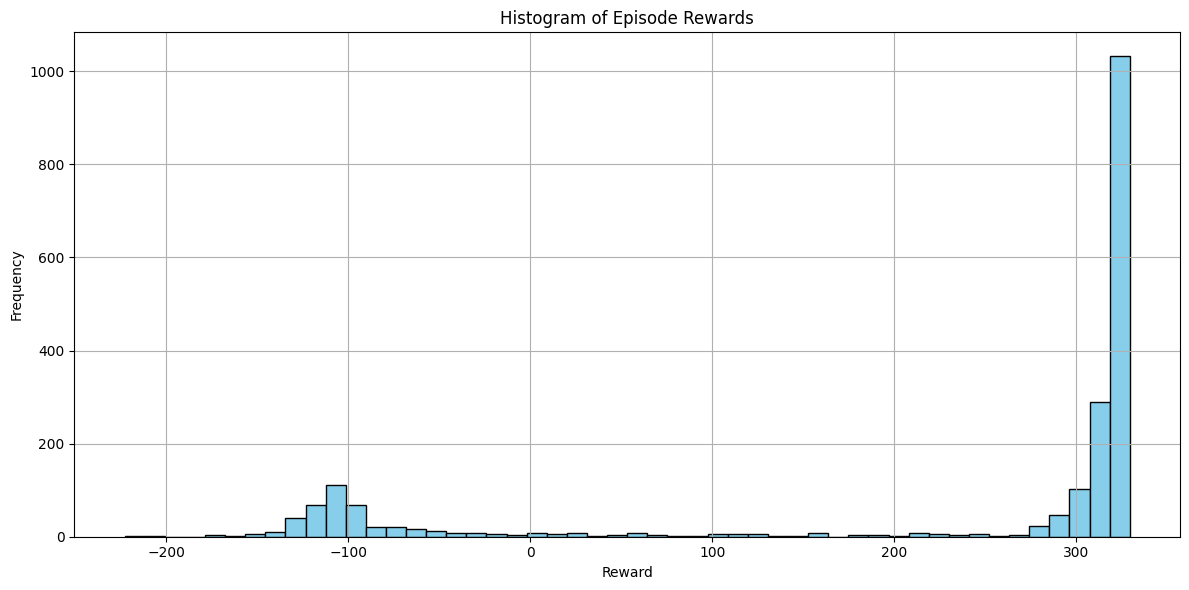

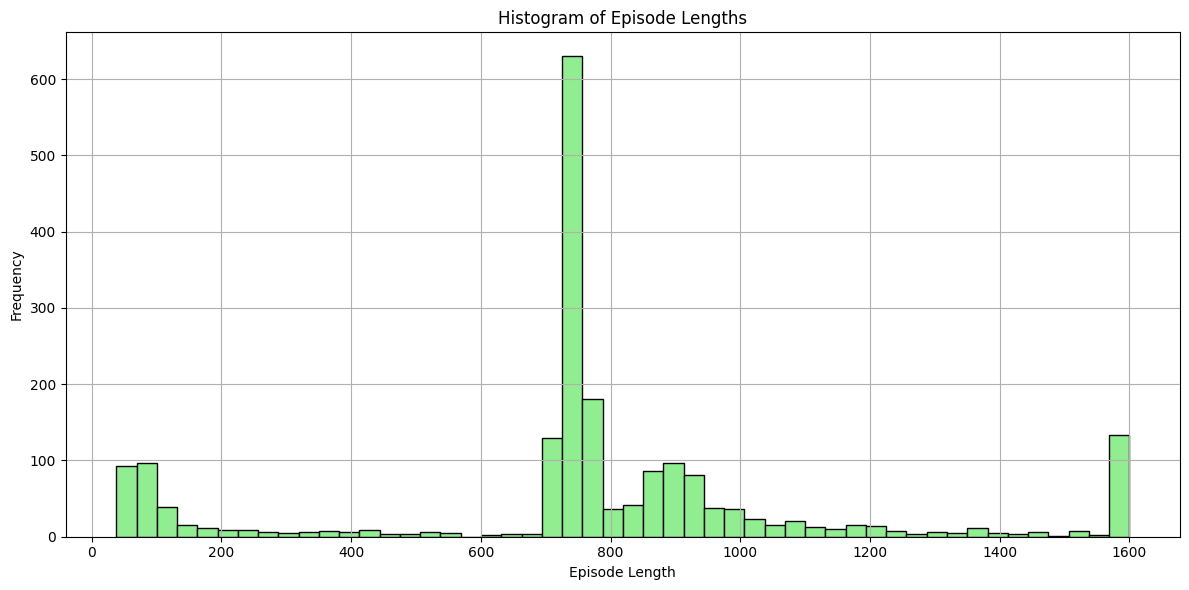

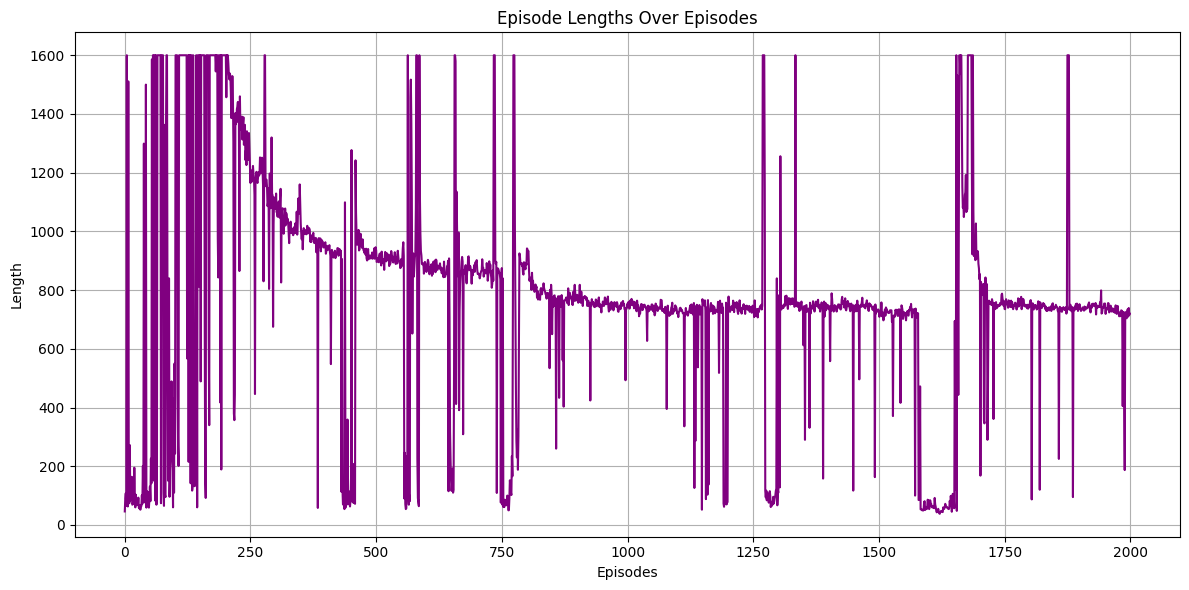

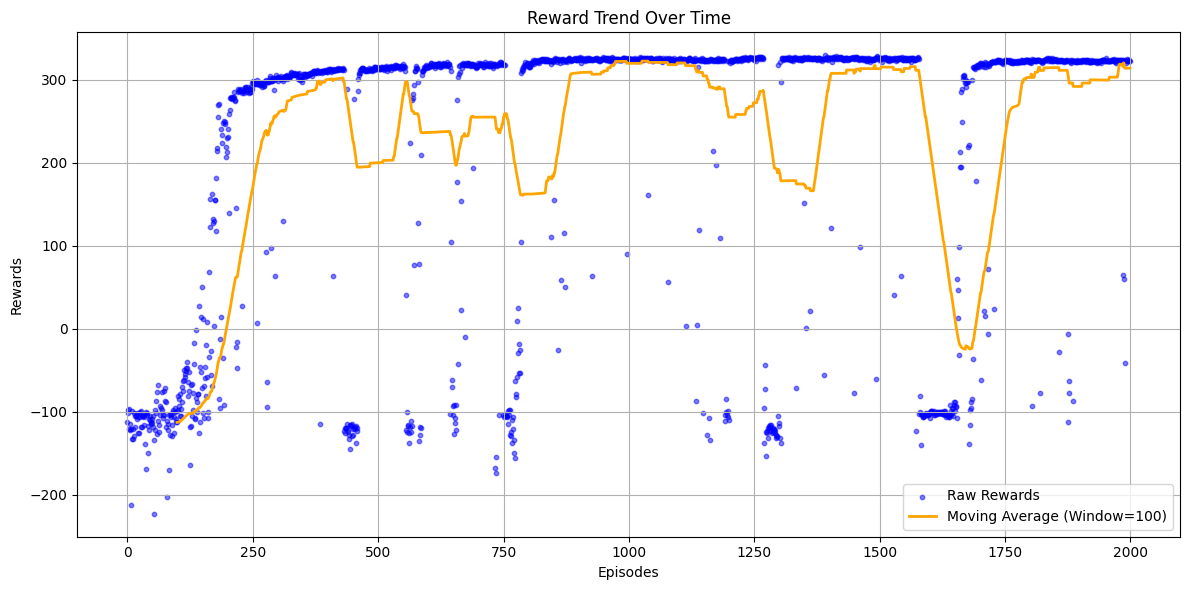

Plots generated and saved to 'plots' directory.


In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
rewards = np.load('sb3_score_history.npy')
episode_lengths = np.load('sb3_episode_lengths.npy')

# Moving average filter
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Apply moving average filter to rewards
window_size = 100
smoothed_rewards = moving_average(rewards, window_size)

# Plot raw rewards and smoothed rewards
plt.figure(figsize=(12, 6))
plt.plot(rewards, label='Raw Rewards')
plt.plot(range(window_size - 1, len(rewards)), smoothed_rewards, label=f'Moving Average (Window={window_size})', color='orange', linewidth=2)
plt.title('Episode Rewards with and without Moving Average')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('plots/rewards_with_moving_average.png')
plt.show()

# Plot histogram of episode rewards
plt.figure(figsize=(12, 6))
plt.hist(rewards, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Episode Rewards')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.grid()
plt.tight_layout()
plt.savefig('plots/reward_histogram.png')
plt.show()

# Plot histogram of episode lengths
plt.figure(figsize=(12, 6))
plt.hist(episode_lengths, bins=50, color='lightgreen', edgecolor='black')
plt.title('Histogram of Episode Lengths')
plt.xlabel('Episode Length')
plt.ylabel('Frequency')
plt.grid()
plt.tight_layout()
plt.savefig('plots/length_histogram.png')
plt.show()

# Plot episode lengths over episodes
plt.figure(figsize=(12, 6))
plt.plot(episode_lengths, label='Episode Lengths', color='purple')
plt.title('Episode Lengths Over Episodes')
plt.xlabel('Episodes')
plt.ylabel('Length')
plt.grid()
plt.tight_layout()
plt.savefig('plots/episode_lengths_over_time.png')
plt.show()

# Reward trend over time (scatter plot)
plt.figure(figsize=(12, 6))
plt.scatter(range(len(rewards)), rewards, s=10, color='blue', alpha=0.5, label='Raw Rewards')
plt.plot(range(window_size - 1, len(rewards)), smoothed_rewards, label=f'Moving Average (Window={window_size})', color='orange', linewidth=2)
plt.title('Reward Trend Over Time')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('plots/reward_trend_scatter.png')
plt.show()

# Save additional summary statistics as a text file
summary_stats = {
    "mean_reward": np.mean(rewards),
    "std_reward": np.std(rewards),
    "min_reward": np.min(rewards),
    "max_reward": np.max(rewards),
    "mean_episode_length": np.mean(episode_lengths),
    "std_episode_length": np.std(episode_lengths),
    "min_episode_length": np.min(episode_lengths),
    "max_episode_length": np.max(episode_lengths)
}

with open('plots/rewards_summary.txt', 'w') as f:
    for key, value in summary_stats.items():
        f.write(f"{key}: {value}\n")

print("Plots generated and saved to 'plots' directory.")
